/home/tj/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Start ==> preprocessing for test
Tensor("shuffle_batch:0", shape=(32, 224, 224, 3), dtype=float32)
Tensor("Predictions/Reshape_1:0", shape=(32, 365), dtype=float32)
INFO:tensorflow:Restoring parameters from ./output/models/scene_recognition_final.ckpt
Evaluating...
(32, 224, 224, 3)


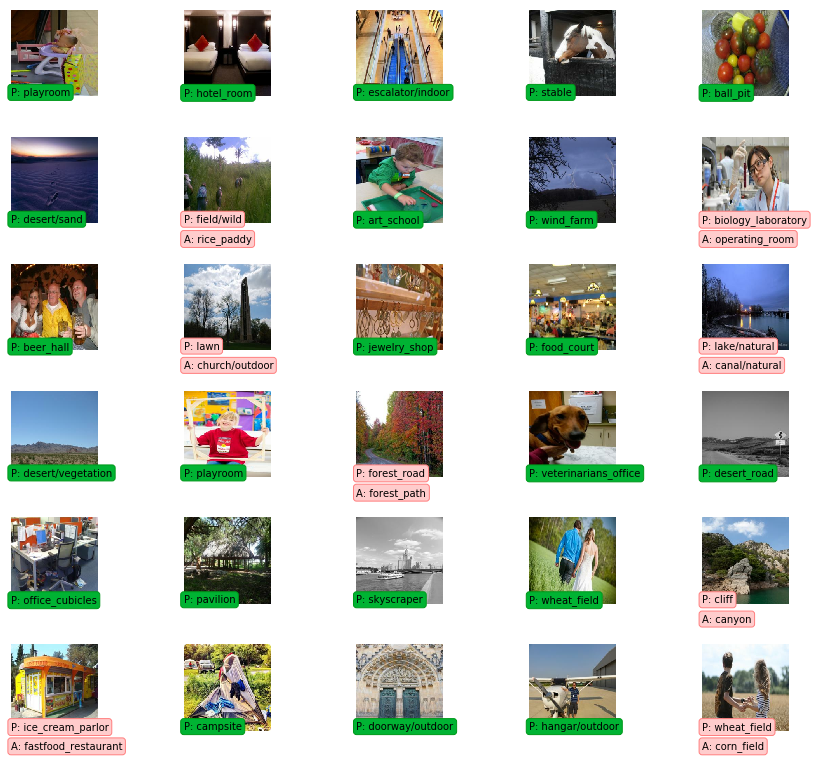

Done.


In [1]:
import os
from time import gmtime, strftime
import numpy as np
import random, math
import tensorflow as tf
import configs.config as cfg
import networks.mobilenet_V2 as model
import data.datapipe as datasets
import scipy.misc as sm
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim

FLAGS = tf.app.flags.FLAGS

num_classes = FLAGS.num_classes
batch_size = FLAGS.batch_size
model_path = FLAGS.checkpoint_model

meta_dir = FLAGS.dataset_dir + '/meta/'
class_file = open(meta_dir + 'categories_places365.txt', 'r')

classes = []
for line in class_file:
    classes.append(line.strip().split(' ')[0][3:])
labels_to_class = dict(zip(range(len(classes)), classes))

image, target_labels = datasets.get_dataset(FLAGS.surfix, is_training=False, im_batch=batch_size)

nets = model.MobileNet_V2(image,
                       num_classes=num_classes,
                       is_training=False,
                       weight_decay=FLAGS.weight_decay)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
saver = tf.train.Saver()

with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:
    sess.run(init_op)
    saver.restore(sess, model_path)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    print('Evaluating...')
    try:
        while not coord.should_stop():
            imgs, t_cls, p_cls = sess.run([image, target_labels, nets.end_points['predictions']])
            print(imgs.shape)
#             imgs = (imgs + 1.0) / 2.0
            preds = np.argmax(p_cls, axis=1)
            top_n_preds = np.argpartition(p_cls, -5)[:, -5:]

            fig, axes = plt.subplots(6, 5, figsize=(12, 12))
            fig.set_size_inches(12, 14)
            for idx, ax in enumerate(axes.flat):
                im = ax.imshow(imgs[idx])
                ax.set_axis_off()
                ax.title.set_visible(False)
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                for spine in ax.spines.values():
                    spine.set_visible(False)
                p_name = labels_to_class[preds[idx]]
                t_name = labels_to_class[t_cls[idx]]
                match = p_name == t_name
                if match:
                    ec = (0, 0.6, 0.1)
                    fc = (0, 0.7, 0.2)
                else:
                    ec = (1, 0.5, 0.5)
                    fc = (1, 0.8, 0.8)

                ax.text(0, 200, 'P: ' + p_name, size=10, rotation=0, ha='left', va='top',
                        bbox=dict(boxstyle='round', ec=ec, fc=fc, ))
                if not match:
                    ax.text(0, 250, 'A: ' + t_name, size=10, rotation=0, ha='left', va='top',
                            bbox=dict(boxstyle='round', ec=ec, fc=fc, ))
            plt.subplots_adjust(left=0, wspace=1, hspace=0)
            plt.show()
            break
    except tf.errors.OutOfRangeError:
        print('Error is occured and stop the training')
    finally:
        coord.request_stop()
    coord.join(threads)
print('Done.')